## Parsing Mini-EUSO log files

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import dates as mdates
import datetime
from datetime import date, time

In [2]:
filename = 'test_data/CPU_MAIN__2020_02_21__18_29_19.log'
search_str = 'average photodiode reading is:'
day_str = 'entering DAY mode'
night_str = 'entering NIGHT mode'

In [3]:
# Set date
my_day = date(2020, 2, 21)

In [81]:
# Grab photodiode read logs, ignoring ones that get cut off
lines = [line.rstrip('\n') for line in open(filename) if 
         ((search_str in line) and (len(line) > 65))]

# Grab DAY/NIGHT siwtching times
day_lines = [line.rstrip('\n') for line in open(filename) if 
             day_str in line and len(line) > 49]
night_lines = [line.rstrip('\n') for line in open(filename) if 
               (night_str in line and len(line)>26)]

In [99]:
l = lines[0]
start = l.find(search_str)
l[start+31:start+33]

'30'

In [83]:
l = night_lines[0]
start = l.find(search_str)
ts = l[start-40:start-25]
ts

'18:30:23.969320'

In [102]:
# loop through and parse details (timestamp and photodiode value)
day = []
timestamp = []
photodiode = []
for l in lines:
    start = l.find(search_str)
    day.append(date(int(l[start-33:start-29]), 
                    int(l[start-28:start-26]), 
                    int(l[start-25:start-23])))
    ts = l[start-22:start-7]
    timestamp.append(time(hour=int(ts[0:2]), minute=int(ts[3:5]), 
                          second=int(ts[6:8]), microsecond=int(ts[9:15])))
    photodiode.append(float(l[start+31:start+33]))

# Combine day and timestamp
x_dt = [ datetime.datetime.combine(d, t) for d, t in zip(day, timestamp) ]

In [104]:
# Parse switching times
day = []
day_switch = []
for l in day_lines:
    start = l.find(search_str)
    day.append(date(int(l[start-49:start-45]), 
                   int(l[start-44:start-42]), 
                   int(l[start-41:start-39])))
    ts = l[start-38:start-23]
    day_switch.append(time(hour=int(ts[0:2]), minute=int(ts[3:5]), 
                              second=int(ts[6:8]), microsecond=int(ts[9:15])))
x_day = [ datetime.datetime.combine(d, t) for d, t in zip(day, day_switch) ]

day = []
night_switch = []
for l in night_lines:
    start = l.find(search_str)
    day.append(datetime.date(int(l[start-51:start-47]), 
                             int(l[start-46:start-44]), 
                             int(l[start-43:start-41])))
    ts = l[start-40:start-25]
    night_switch.append(time(hour=int(ts[0:2]), minute=int(ts[3:5]), 
                              second=int(ts[6:8]), microsecond=int(ts[9:15])))

x_night = [ datetime.datetime.combine(d, t) for d, t in zip(day, night_switch) ]

## Plot results

In [105]:
plt.style.use('minimalist')

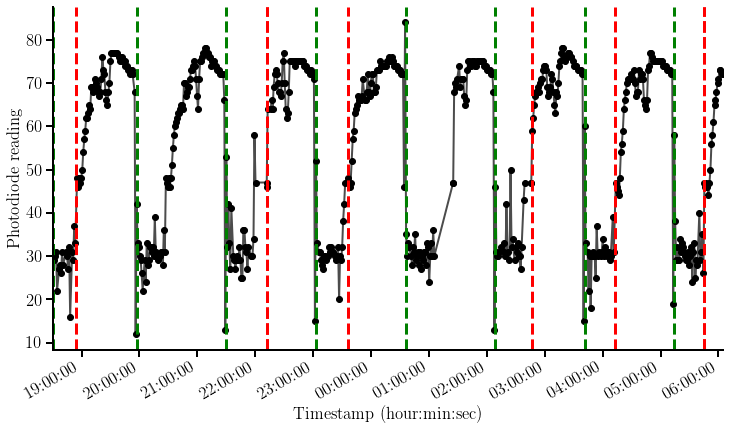

In [106]:
fig, ax = plt.subplots()
fig.set_size_inches((12, 7))
ax.plot(x_dt, photodiode, 'ko')
ax.plot(x_dt, photodiode, 'k', alpha=0.7)
for d in x_day:
    ax.axvline(d, color='r', linestyle='--', lw=3)
for n in x_night:
    ax.axvline(n, color='g', linestyle='--', lw=3)
myFmt = mdates.DateFormatter('%H:%M:%S')
ax.xaxis.set_major_formatter(myFmt)
fig.autofmt_xdate()
ax.set_xlabel('Timestamp (hour:min:sec)')
ax.set_ylabel('Photodiode reading')
ax.set_xlim(x_dt[0])
fig.savefig('figures/photodiode_timeseries.pdf', dpi=500, bbox_inches='tight')

## Time between photodiode readings

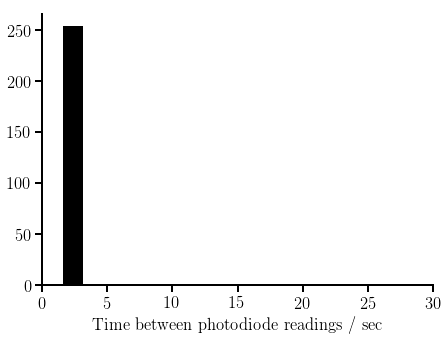

In [13]:
delta_t = np.array(x_dt[1:]) - np.array(x_dt[0:-1])
delta_t = [_.seconds for _ in delta_t]

fig, ax = plt.subplots()
ax.hist(delta_t, bins=np.linspace(0, 30, 20));
ax.set_xlabel('Time between photodiode readings / sec')
fig.savefig('figures/photodiode_time_hist.pdf', dpi=500, bbox_inches='tight')

In [42]:
np.mean(delta_t)

74.76333333333334

## Time between high photodiode value and switch

In [18]:
threshold = 100 # NIGHT -> DAY